<a href="https://colab.research.google.com/github/jajinkya/MRI-image-translation-T1-to-T2-using-cyclegan/blob/main/Image_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Required Libraries

In [ ]:
import os 
import glob 
import numpy as np
import pandas as pd
import cv2 as cv
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

In [ ]:
cd /content/drive/MyDrive/Deep Learning/GAN/T1_to_T2 MRI image

/content/drive/MyDrive/Deep Learning/GAN/T1_to_T2 MRI image


In [ ]:
os.getcwd()

'/content/drive/MyDrive/Deep Learning/GAN/T1_to_T2 MRI image'

In [ ]:
tr1_path = os.getcwd()+ '/Tr1'
tr2_path = os.getcwd()+'/Tr2'

In [ ]:
tr1 = tf.keras.preprocessing.image_dataset_from_directory(
    tr1_path,
    labels="inferred",
    label_mode=None,
    class_names=None,
    color_mode="grayscale",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    interpolation="nearest",
    follow_links=False,
)

Found 43 files belonging to 1 classes.


In [ ]:
tr2 = tf.keras.preprocessing.image_dataset_from_directory(
    tr2_path,
    labels="inferred",
    label_mode=None,
    class_names=None,
    color_mode="grayscale",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    interpolation="nearest",
    follow_links=False,
)

Found 46 files belonging to 1 classes.


## Image Processing

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, dtype = tf.float32)
    image = image / 127.5 - 1 
    return image

In [ ]:
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image) # augmentation technique
    image = normalize(image)
    return image

In [ ]:
# process both classes of MRI images
AUTOTUNE = tf.data.experimental.AUTOTUNE

tr1 = tr1.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache()

tr2 = tr2.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache()


In [ ]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

In [ ]:
sample_tr1.shape

TensorShape([1, 256, 256, 1])

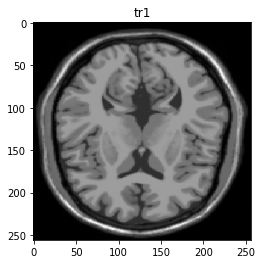

In [ ]:
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0]*0.5 + 0.5, cmap='gray')

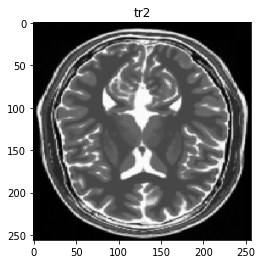

In [ ]:
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0]*0.5 + 0.5, cmap='gray')

## Hyperparameters 

In [ ]:
dropout = 0.5  
LAMBDA = 1                     # weight of cyclic and identity loss
LAMBDA_adversarial = 0.5       # weight of discriminator loss
learning_rate_G = 2e-4 # learning rate for generator 
learning_rate_D = 2e-4 # learning rate for discriminator
beta_1 = 0.5 # exponential decay rate for the 1st moment estimates
beta_2 = 0.999 # exponential decay rate for the 2nd moment estimates
EPOCHS = 200 

## Model Building & Training

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon= 1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape= input_shape[-1:],
            initializer= tf.random_normal_initializer(1., 0.02),
            trainable = True
        )
        self.offset = self.add_weight(
            name= 'offset',
            shape = input_shape[-1:],
            initializer = 'zeros',
            trainable = True
        )
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes = [1,2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm= True):
    initializer = tf.random_normal_initializer(0, 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer= initializer, use_bias=False))
    
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.ReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0, 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer= initializer,use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(dropout))
    result.add(tf.keras.layers.ReLU())
    return result


In [ ]:
def unet_generator():
    down_stack = [
                  downsample(64, 4, False), # (bs, 128, 128, 64)
                  downsample(128, 4), # (bs, 64, 64, 128)
                  downsample(256, 4), # (bs, 32, 32, 256)
                  downsample(512, 4), # (bs, 16, 16, 512)
                  downsample(512, 4), # (bs, 4, 4, 512)
                  downsample(512, 4), # (bs, 2, 2, 512)
                  downsample(512, 4) # (bs, 1, 1,512)
    ]
    up_stack = [
                upsample(512, 4, True), # (bs, 2, 2, 1024)
                upsample(512, 4, True), # (bs, 4, 4, 1024)
                upsample(512, 4, True), # (bs, 8, 8, 1024)
                upsample(512, 4,), # (bs, 16, 16, 1024)
                upsample(256, 4,), # (bs, 32, 32, 512)
                upsample(128, 4,), # (bs, 64, 64, 256)
                upsample(64, 4,), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)

    concat =  tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs= inputs, outputs=x)

In [ ]:
generator_g = unet_generator() # instantiate generator
generator_f = unet_generator()

In [ ]:
def discriminator():
    initializer = tf.random_normal_initializer(0, 0.02)
    inp = tf.keras.layers.Input(shape= [None, None, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) #(bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer= initializer,
                                  use_bias = False)(zero_pad1) # (bs, 31, 31, 512)
    norml = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norml)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer = initializer)(zero_pad2) #(bs, 30, 30, 1)
    return tf.keras.Model(inputs = inp, outputs= last)

In [ ]:
discriminator_x = discriminator() #initialise the discriminator
discriminator_y = discriminator() #initialise the discriminator

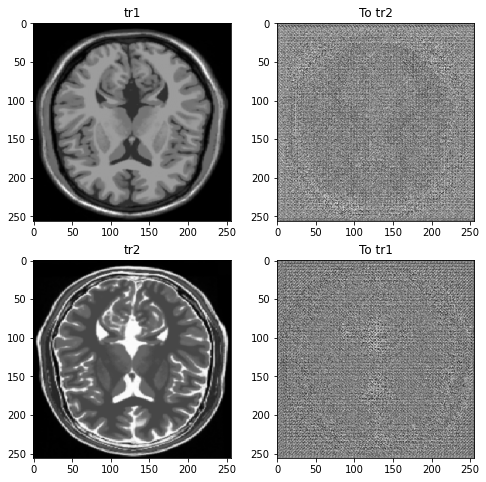

In [ ]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * LAMBDA_adversarial


In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image -same_image))
    return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate_G, beta_1 = beta_1, beta_2=beta_2)
generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate_G, beta_1= beta_1, beta_2=beta_2)

discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate_D, beta_1=beta_1, beta_2=beta_2)
discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate_D, beta_1=beta_1, beta_2=beta_2)

In [ ]:
checkpoint_path = os.getcwd()+ '/checkpoint' # path to store checkpoints

ckpt = tf.train.Checkpoint(generator_g = generator_g,
                           generator_f = generator_f,
                           discriminator_x = discriminator_x,
                           discriminator_y = discriminator_y, 
                           generator_g_optimizer = generator_g_optimizer,
                           generator_f_optimizer = generator_f_optimizer,
                           discriminator_x_optimizer = discriminator_x_optimizer,
                           discriminator_y_optimizer = discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# if a checkpoint exists, restore the latest checkpoint
if ckpt_manager.latest_checkpoint:
    ckpt.manager(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')


In [ ]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
@tf.function

def train_step(real_x, real_y):
    #persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent= True) as tape:
        # Generator G translates X --> Y
        # Generator F translates Y --> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training= True)

        fake_x = generator_f(real_y, training= True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training = True)
        same_y = generator_g(real_y, training= True)

        disc_real_x = discriminator_x(real_x, training = True)
        disc_real_y = discriminator_y(real_y, training = True)

        disc_fake_x = discriminator_x(fake_x, training= True)
        disc_fake_y = discriminator_y(fake_y, training= True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss,
                                          generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,
                                          generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss,
                                              discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,
                                              discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                              generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                              generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                  discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                  discriminator_y.trainable_variables))
    
    return {
            "total_gen_g_loss": total_gen_g_loss,
            "total_gen_f_loss": total_gen_f_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss,
        }

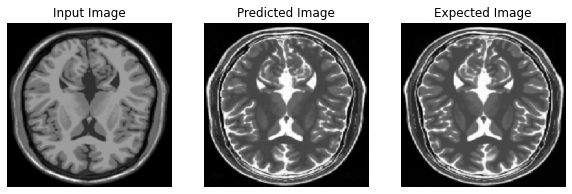

Average Generator loss G at epoch 200 : 0.8601300120353699
Average Generator loss F at epoch 200 : 0.7608199715614319
Average Discriminator loss X at epoch 200 : 0.6920599937438965
Average Discriminator loss Y at epoch 200 : 0.6590999960899353

time taken at epoch 200 is 29 sec



In [ ]:
for epoch in range(EPOCHS):

    start = time.time()

    n = 0
    total_gen_g_loss=[]
    total_gen_f_loss=[]
    disc_x_loss = []
    disc_y_loss = []


    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        loss = train_step(image_x, image_y)
        total_gen_g_loss.append(loss['total_gen_g_loss'])
        total_gen_f_loss.append(loss['total_gen_f_loss'])
        disc_x_loss.append(loss['disc_x_loss'])
        disc_y_loss.append(loss['disc_y_loss'])

        if n%10==0:
            print('.',end='')
            n+=1
    clear_output(wait=True)
    generate_images(generator_g, sample_tr1, sample_tr2)

    print(f"Average Generator loss G at epoch {epoch+1} : {round(np.array(total_gen_g_loss).mean(),5)}")
    print(f"Average Generator loss F at epoch {epoch+1} : {round(np.array(total_gen_f_loss).mean(),5)}")
    print(f"Average Discriminator loss X at epoch {epoch+1} : {round(np.array(disc_x_loss).mean(),5)}")
    print(f"Average Discriminator loss Y at epoch {epoch+1} : {round(np.array(disc_y_loss).mean(),5)}\n")

    print(f'time taken at epoch {epoch+1} is {round(time.time()-start)} sec\n')

In [ ]:
ckpt_save_path = ckpt_manager.save()

In [ ]:
def generate_images_test(model, test_input, ):
    prediction = model(test_input)
    plt.figure(figsize=(5, 5))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image',]
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

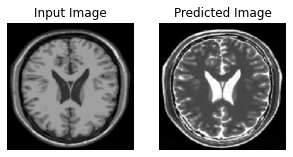

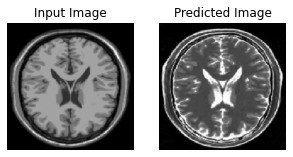

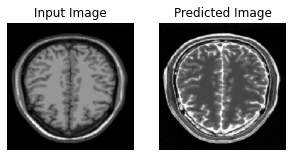

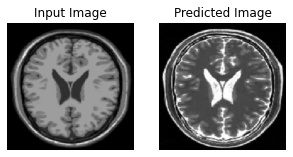

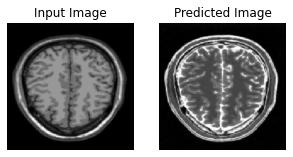

In [ ]:
# Run the trained model on the test dataset
for inp in tr1.take(5):
    generate_images_test(generator_g, inp)